In [132]:
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

In [234]:
df_origin = pd.read_csv("finalizedDataset.csv",index_col=0)
df = pd.read_csv("finalizedDataset.csv",index_col=0)
df.set_index('Date', inplace=True)
train_X = pd.DataFrame()
test_X = pd.DataFrame()
train_y = pd.DataFrame()
test_y = pd.DataFrame()
for ticker in  df['Ticker'].unique():
    rows = df[df['Ticker'] == ticker]
    y = rows['Price_Stock']
    train_sub_X, test_sub_X, train_sub_y, test_sub_y = train_test_split(rows, y, test_size=0.2, shuffle=False)
    train_X = pd.concat([train_X, train_sub_X ])
    train_y = pd.concat([train_y, train_sub_y])
    test_X = pd.concat([test_X, test_sub_X])
    test_y = pd.concat([test_y, test_sub_y])

train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)
train_y = pd.get_dummies(train_y)
test_y = pd.get_dummies(test_y)

train_scaler = MinMaxScaler()
train_X = train_scaler.fit_transform(train_X)
test_X = train_scaler.transform(test_X)

test_scaler = MinMaxScaler()
train_y = test_scaler.fit_transform(train_y)
test_y = test_scaler.transform(test_y)

train_X = torch.tensor(train_X, dtype=torch.float32) 
test_X = torch.tensor(test_X, dtype=torch.float32) 
train_y = torch.tensor(train_y, dtype=torch.float32) 
test_y = torch.tensor(test_y, dtype=torch.float32) 

In [146]:
sequence = 5
X = []
y = []

for i in range(6):
    start = i*200
    end = (i+1)*200
    for j in range(start+sequence, end):
        X.append(train_X[j-sequence:j,:]) #[0:5] [1:6] ... [2:7] ...
        y.append(train_y[j :j + 1])       #[5:6] [6:7] ... [7:8] ...
X = torch.stack(X, dim=0)
y = torch.stack(y, dim=0)
# 195 sequence per ticker
print(X.shape, y.shape)

torch.Size([1170, 5, 11]) torch.Size([1170, 1, 1])


In [147]:
dataset = TensorDataset(X, y)
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [160]:
class Model(nn.Module):
   def __init__(self, input_size, hidden_size):
      super().__init__()
      self.lstm =  nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=1,batch_first=True)
      self.linear = nn.Linear(hidden_size,1)
      
   def forward(self, X):
      out, _ = self.lstm(X)
      out = out[:, -1, :]
      out = self.linear(out)
      return out        

In [162]:
model = Model(11,64)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(50):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'epoch: {epoch + 1} loss: {running_loss:.3f}')

epoch: 1 loss: 8.924
epoch: 2 loss: 6.161
epoch: 3 loss: 4.759
epoch: 4 loss: 3.686
epoch: 5 loss: 2.917
epoch: 6 loss: 2.398
epoch: 7 loss: 2.052
epoch: 8 loss: 1.812
epoch: 9 loss: 1.632
epoch: 10 loss: 1.486
epoch: 11 loss: 1.364
epoch: 12 loss: 1.259
epoch: 13 loss: 1.169
epoch: 14 loss: 1.092
epoch: 15 loss: 1.026
epoch: 16 loss: 0.971
epoch: 17 loss: 0.925
epoch: 18 loss: 0.888
epoch: 19 loss: 0.857
epoch: 20 loss: 0.832
epoch: 21 loss: 0.812
epoch: 22 loss: 0.796
epoch: 23 loss: 0.783
epoch: 24 loss: 0.773
epoch: 25 loss: 0.764
epoch: 26 loss: 0.756
epoch: 27 loss: 0.749
epoch: 28 loss: 0.742
epoch: 29 loss: 0.735
epoch: 30 loss: 0.728
epoch: 31 loss: 0.721
epoch: 32 loss: 0.713
epoch: 33 loss: 0.704
epoch: 34 loss: 0.696
epoch: 35 loss: 0.687
epoch: 36 loss: 0.677
epoch: 37 loss: 0.668
epoch: 38 loss: 0.658
epoch: 39 loss: 0.648
epoch: 40 loss: 0.638
epoch: 41 loss: 0.627
epoch: 42 loss: 0.617
epoch: 43 loss: 0.607
epoch: 44 loss: 0.597
epoch: 45 loss: 0.587
epoch: 46 loss: 0.5

In [248]:
X_test = []
y_test = []

for i in range(6):
    start = i*50
    end = (i+1)*50
    for j in range(start+sequence, end):
        X_test.append(test_X[j-sequence:j,:]) #[0:5] [1:6] ... [2:7] ...
        y_test.append(test_y[j :j + 1])       #[5:6] [6:7] ... [7:8] ...
X_test = torch.stack(X_test, dim=0)
y_test = torch.stack(y_test, dim=0)
# 45 sequence per ticker
print(X_test.shape, y_test.shape)

torch.Size([270, 5, 11]) torch.Size([270, 1, 1])


In [216]:
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
actual = []
preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        pred = model(x)
        actual.append(y.squeeze(-1))
        preds.append(pred)
preds = torch.cat(preds, dim=0)
actual = torch.cat(actual,dim=0)

In [282]:
# 54 total, 9 each ticker, 9x5 = 45 days
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plotResults(dates, y, y_pred, title):
    ax = sns.lineplot(x=dates, y=y,label='Actual')
    sns.lineplot(x=dates, y=y_pred, label='Predicted')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', rotation=45)
    plt.title(title)

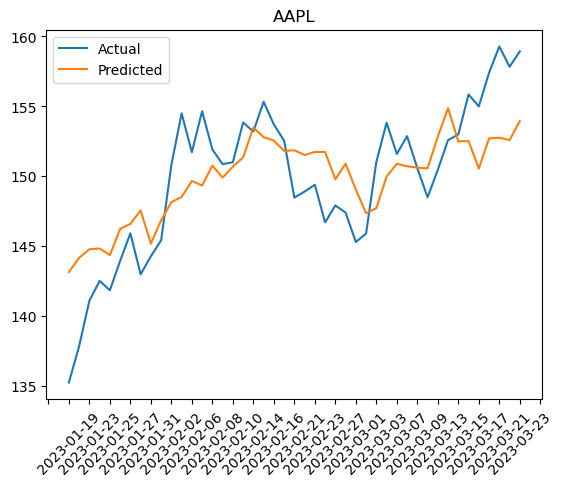

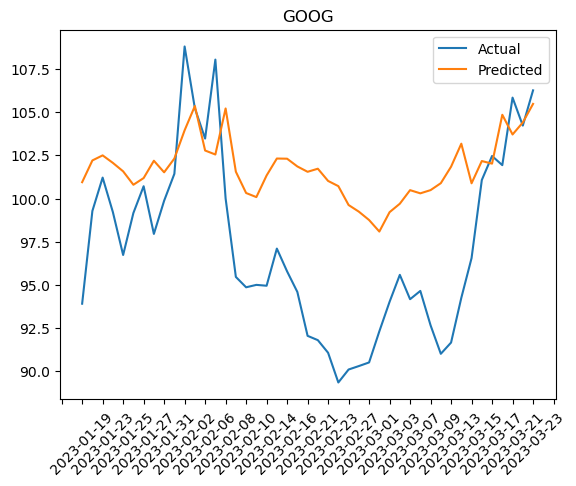

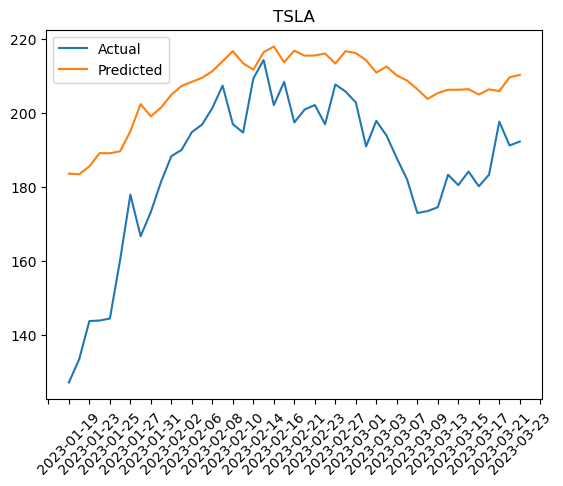

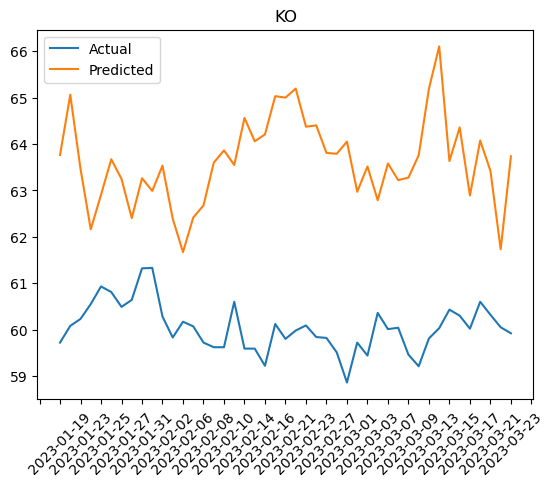

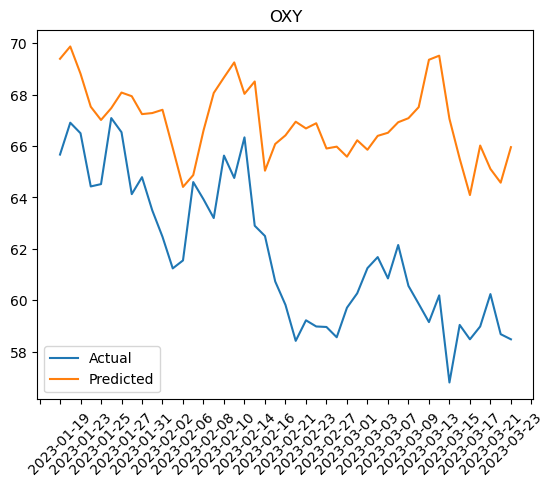

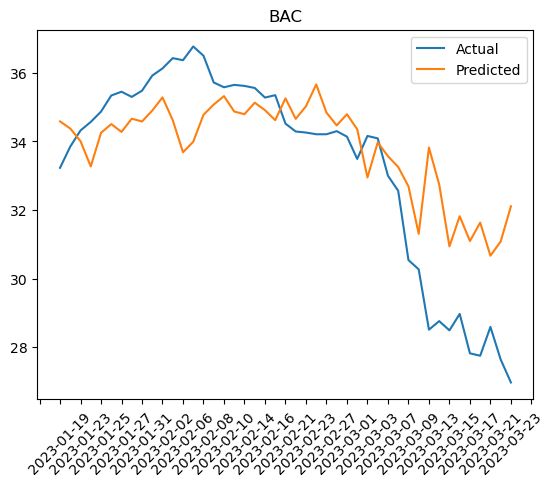

In [283]:
dates = df_origin[200:250]['Date'].values
dates = dates[5:]
ticker = df_origin['Ticker'].unique()
preds_unscaled = test_scaler.inverse_transform(preds)
actual_unscaled = test_scaler.inverse_transform(actual)

for i,t in enumerate(ticker):
    length = 45
    plt.figure()
    plotResults(dates=dates, y=actual_unscaled[i*length:(i+1)*length].reshape(-1),y_pred=preds_unscaled[i*length:(i+1)*length].reshape(-1),title=t)
    plt.show()